### **Capstone Project: SkimLit**

In [79]:
# DL needs
import tensorflow as tf
import keras as kr

# Data needs
import pandas as pd
from sklearn.model_selection import train_test_split

# Numerical computation needs
import numpy as np

# plotting needs
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# ensuring reproducibility
random_seed=42
tf.random.set_seed(random_seed)

import sys
sys.path.append('/home/rudraksha14/Desktop/RAY_RISE_ABOVE_YOURSELF/Programming/tensorflow/')

import important_functionalities as impf

In [80]:
baseline_results = {'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1_score': 0.6989250353450294}

model_1_results = {'accuracy': 78.85939361842976,
 'precision': 0.7857351875581878,
 'recall': 0.7885939361842976,
 'f1_score': 0.7863604692957813}

model_2_results = {'accuracy': 71.4318813716404,
 'precision': 0.714442353759606,
 'recall': 0.714318813716404,
 'f1_score': 0.7113182138257264}

In [81]:
data_dir = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

# check all of the filenames in the target directory
import os 
filenames = [data_dir + filename for filename in os.listdir(data_dir)]

In [82]:
def get_lines(filename):
    '''
    Reads file given a filename (text) and returns the lines of text as a list.
    '''
    with open(filename,'r') as file:
        return file.readlines()

In [83]:
def preprocess_text_with_line_number(filename):
    '''
    Takes in filename (str), reads its content and sorts through each line.
    Extracts things like the target label, the text of the sentence, how many sentences are in the current abstract and what sentence number the target line is.
    Returns a list of dictationaries of abstract line data.
    '''

    input_lines = get_lines(filename) # get all lines from file name
    abstract_lines = '' # create an empty abstract 
    abstract_samples = [] # create an empty list of abstracts

    # loop through each line in the target file
    for line in input_lines:
        if line.startswith('###'): # check to see if line is an ID line
            abstract_id = line
            abstract_lines = "" # reset the abstract string for every new abstract
            
        elif line.isspace(): # check to see if line is a newline
            abstract_lines_split = abstract_lines.splitlines() # split abstract into separate lines ('\n')

            # this is one particular abstract we are dealing with
            # iterate through each line in a single abstract, and count them at the same time.
            for abstract_line_no,abstract_line in enumerate(abstract_lines_split):
                line_data = {} # create an empty dictationary for each line
                target_text_split = abstract_line.split("\t")
                # text before \t is label, and after \t is text

                line_data['target'] = target_text_split[0] # get target label
                line_data['text'] = target_text_split[1].lower() # get target text and lowercase it
                line_data['line_number'] = abstract_line_no # what number line does the line appear in the abstract?
                line_data["total_lines"] = len(abstract_lines_split) - 1 # how many total lines are there in the target abstract ? (start from 0)
                
                # add line data to abstract samples list
                abstract_samples.append(line_data)

        else: # if the above conditions are not fulfilled, the line contains a labelled sentence
            abstract_lines += line
    
    return abstract_samples

In [84]:
%%time
# get data from file and pre-process it

train_samples = preprocess_text_with_line_number(data_dir+'train.txt')
val_samples = preprocess_text_with_line_number(data_dir+'dev.txt')
test_samples = preprocess_text_with_line_number(data_dir+'test.txt')
len(train_samples),len(val_samples),len(test_samples)

CPU times: user 453 ms, sys: 97.3 ms, total: 550 ms
Wall time: 547 ms


(180040, 30212, 30135)

In [85]:
# # turning data into dataframe to further visualize
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [86]:
train_sentences = train_df['text'].to_list()
val_sentences = val_df['text'].to_list()
test_sentences = test_df['text'].to_list()
len(train_sentences),len(val_sentences),len(test_sentences)

(180040, 30212, 30135)

In [87]:
# NUMERIC_LABELLING
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df['target'].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [88]:
# ONE_HOT_ENCODING
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse_output=False) # we want non-sparse matrix

train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df['target'].to_numpy().reshape(-1,1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [89]:
# Get the class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
# print(class_names,num_classes)

**8. Creating character-level tokenizer**

* The paper uses a combination of token and character-level embeddings.

In [90]:
# make function to split sentence into characters
def split_chars(text):
    return " ".join(list(text))

split_chars("The quick brown fox jumped over the lazy dog")

'T h e   q u i c k   b r o w n   f o x   j u m p e d   o v e r   t h e   l a z y   d o g'

In [91]:
# split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [92]:
# finding the average character length
char_lens = [len(sentence) for sentence in train_sentences]
avg_char_len = tf.reduce_mean(char_lens)
avg_char_len

<tf.Tensor: shape=(), dtype=int32, numpy=149>

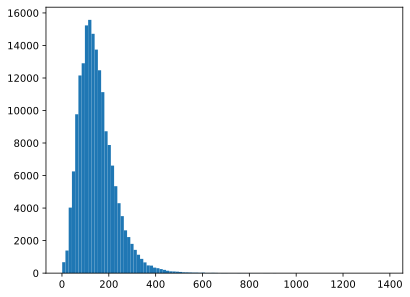

In [93]:
# check the distribution of our sequences at a character level
plt.hist(char_lens,bins = 100);

In [94]:
# finding the max char-len
tf.reduce_max(char_lens)

<tf.Tensor: shape=(), dtype=int32, numpy=1386>

In [95]:
# finding what length of characters covers 95% of our dataset
output_char_seq_len = int(np.percentile(char_lens,95))
output_char_seq_len

290

In [96]:
# max char-tokens (total number of unique characters available)
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
print(alphabet)


# the length of this covers all basis for our characters
MAX_CHAR_TOKENS = len(alphabet) + 2 # alphabet doesn't include space & OOV (OUT OF VOCAB '[UNK]') token
print(MAX_CHAR_TOKENS)

# Vocabulary size (refer paper: for PUBMED-20k it is 68k)
MAX_TOKENS  = 68000

abcdefghijklmnopqrstuvwxyz0123456789!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
70


In [97]:
# creating the text-vectorizer (char-level) layer
text_char_vectorizer = tf.keras.layers.TextVectorization(max_tokens = MAX_CHAR_TOKENS, # no of unique chars
                                                    output_sequence_length = output_char_seq_len, # desired output length of vectorized sequences
                                                    # all other params kept default,
                                                    name = 'text_char_vectorizer',
                                                    # standardize = None
                                                    standardize = 'lower_and_strip_punctuation'
                                                    )
# we will keep the `default standardization on`
# we set `standardize to None` if we want punctuation to be preserved

In [98]:
# adapt the text char vectorizer (char level) to train chars
text_char_vectorizer.adapt(train_chars)

In [99]:
# character vocab stats
char_vocab = text_char_vectorizer.get_vocabulary()
print(f'Number of different chars in char vocab:{len(char_vocab)}')
print(f'Most common chars in vocab:{char_vocab[:5]}')
print(f'Least common chars in vocab:{char_vocab[-5:]}')

Number of different chars in char vocab:28
Most common chars in vocab:['', '[UNK]', 'e', 't', 'i']
Least common chars in vocab:['k', 'x', 'z', 'q', 'j']


In [100]:
# show an example char vectorization
import random
target_chars = random.choice(train_chars)
print(f'Charified Text:\n{target_chars}')
print(f'\nLength of charified text: {len(target_chars.split())}')
print(f'\nVectorized text: {text_char_vectorizer([target_chars])} ')
print(f'\nLength of vectorized text: {len(text_char_vectorizer([target_chars])[0])}')

Charified Text:
e v e n   t h o u g h   c p a p   p r o v e d   t o   b e   m o r e   e f f e c t i v e   a t   a t t e n u a t i n g   o s a   ,   b e t t e r   c o m p l i a n c e   w i t h   m a d   f a v o r e d   t h e   r e d u c t i o n   o f   o n e   o f   t h e   e n z y m e s   w h i c h   p a r t i c i p a t e s   i n   o x i d a t i v e   s t r e s s   a n d   b e t t e r   a u t o n o m i c   m o d u l a t i o n   d u r i n g   s l e e p   .

Length of charified text: 187

Vectorized text: [[ 2 21  2  6  3 13  7 16 18 13 11 14  5 14 14  8  7 21  2 10  3  7 22  2
  15  7  8  2  2 17 17  2 11  3  4 21  2  5  3  5  3  3  2  6 16  5  3  4
   6 18  7  9  5 22  2  3  3  2  8 11  7 15 14 12  4  5  6 11  2 20  4  3
  13 15  5 10 17  5 21  7  8  2 10  3 13  2  8  2 10 16 11  3  4  7  6  7
  17  7  6  2  7 17  3 13  2  2  6 25 19 15  2  9 20 13  4 11 13 14  5  8
   3  4 11  4 14  5  3  2  9  4  6  7 24  4 10  5  3  4 21  2  9  3  8  2
   9  9  5  6 10 22  2  3  3  2  8  5 16  3  7 

**9. Creating character-level embedding layer**

* Dimension of embedding of each character vector = 25 (used in paper) [fig.1]

In [101]:
char_embedding = tf.keras.layers.Embedding(input_dim = MAX_CHAR_TOKENS, # number of different chars
                                           output_dim = 25,
                                           mask_zero = True,
                                           name = 'char_embed'
                                           )

In [102]:
# test out character-embedding layer
target_chars = random.choice(train_chars)
print(f'Charified Text:\n{target_chars}')
print(f'\nLength of charified text: {len(target_chars.split())}')
print(f'\nEmbedded text: {char_embedding(text_char_vectorizer(target_chars))} ')
print(f'\nLength of embedded text: {char_embedding(text_char_vectorizer([target_chars])).shape}')

Charified Text:
t h e y   w e r e   t h e n   r a n d o m i z e d   t o   r e c e i v e   e d u c a t i o n a l   p a m p h l e t s   w r i t t e n   a t   e i t h e r   a   g r a d e   @   (   i n t e r v e n t i o n   g r o u p   )   o r   g r a d e   @   (   c o n t r o l   g r o u p   )   r e a d i n g   l e v e l   .

Length of charified text: 127

Embedded text: [[ 0.00558877  0.04075036 -0.04309944 ...  0.02846863 -0.03594651
   0.03381069]
 [-0.02105643  0.00428282  0.02247739 ...  0.04853291 -0.04702302
  -0.01290007]
 [-0.04929649  0.00288058  0.02605183 ...  0.01069862 -0.04102621
  -0.03158432]
 ...
 [ 0.00571068 -0.02318544  0.02373482 ...  0.02376072  0.03514378
   0.04792518]
 [ 0.00571068 -0.02318544  0.02373482 ...  0.02376072  0.03514378
   0.04792518]
 [ 0.00571068 -0.02318544  0.02373482 ...  0.02376072  0.03514378
   0.04792518]] 

Length of embedded text: (1, 290, 25)


In [103]:
import tensorflow_hub as hub
@kr.saving.register_keras_serializable(package="my_custom_package")
class UniversalEncodedLayer(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
        self.use_layer = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2",
                                        input_shape = [],
                                        dtype=tf.string,
                                        trainable=False, # default=False,
                                        name='USE'
                                        )

    def call(self,inputs):
        return self.use_layer(inputs)


In [104]:
# creating datasets for sequence data using tf.data API

### Turn our data into tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))

### Take the Tensor slice datasets and turn them into prefetched datasets
BATCH_SIZE = 32
train_dataset = train_dataset.batch(batch_size = BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(batch_size = BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size = BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [105]:
# creating datasets for character data using tf.data API

### Turn our data into tensorflow datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot))
valid_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot))
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars,test_labels_one_hot))

### Take the Tensor slice datasets and turn them into prefetched datasets
BATCH_SIZE = 32
train_char_dataset = train_char_dataset.batch(batch_size = BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_char_dataset = valid_char_dataset.batch(batch_size = BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_char_dataset = test_char_dataset.batch(batch_size = BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

**10. Model 3: Conv1D with character embeddings**

In [106]:
inputs = tf.keras.layers.Input(shape = (1,),dtype=tf.string)
character_vectorization = text_char_vectorizer(inputs)
character_embeddings = char_embedding(character_vectorization)
x = tf.keras.layers.Conv1D(filters = 128,
                           kernel_size = 5,
                           padding = 'same',
                           activation = 'relu'
                           )(character_embeddings)
x = tf.keras.layers.GlobalMaxPooling1D()(x) # condense the output of our feature vector from conv layers
outputs = tf.keras.layers.Dense(units = num_classes,activation = 'softmax')(x)

# create the model
model_3 = tf.keras.models.Model(inputs = inputs, outputs=outputs)
model_3.summary()

/home/rudraksha14/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'conv1d_2' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_char_vectorizer            │ (None, 290)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ char_embed (Embedding)          │ (None, 290, 25)        │         1,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 290, 128)       │        16,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,523 (72.36 KB)

 Trainable params: 18,523 (72.36 KB)

 Non-trainable params: 0 (0.00 B)

In [107]:
# compile the model
model_3.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'])

In [108]:
# fitting the model
model_3.fit(train_char_dataset,
            steps_per_epoch = int(0.1*len(train_char_dataset)),
            epochs = 3,
            validation_data = valid_char_dataset,
            validation_steps = int(0.1*len(valid_char_dataset))
            )

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.4475 - loss: 1.3555 - val_accuracy: 0.6134 - val_loss: 0.9866
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.6160 - loss: 0.9765 - val_accuracy: 0.6602 - val_loss: 0.8785
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.6570 - loss: 0.8816 - val_accuracy: 0.6795 - val_loss: 0.8271


In [109]:
# evaluate model 1
model_3.evaluate(valid_char_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6760 - loss: 0.8340


[0.8362155556678772, 0.6766847372055054]

In [110]:
# make predictions using model 1
model_3_pred_probs = model_3.predict(valid_char_dataset)
model_3_pred_probs,model_3_pred_probs.shape

945/945 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


(array([[0.13612036, 0.49833092, 0.09603418, 0.24810761, 0.02140686],
        [0.15280598, 0.65460795, 0.02173664, 0.1161648 , 0.05468463],
        [0.09523655, 0.29979262, 0.1630999 , 0.42358392, 0.01828698],
        ...,
        [0.0085361 , 0.04724803, 0.06336651, 0.01874239, 0.862107  ],
        [0.01968143, 0.09229571, 0.24126078, 0.01473219, 0.63202983],
        [0.36870357, 0.41426322, 0.11933685, 0.0887411 , 0.00895519]],
       dtype=float32),
 (30212, 5))

In [111]:
# convert pred-probs to classes

pred_labels = tf.argmax(model_3_pred_probs,axis=1)
pred_classes  = [class_names[label] for label in pred_labels]
pred_labels,pred_classes

(<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>,
 ['CONCLUSIONS',
  'CONCLUSIONS',
  'OBJECTIVE',
  'METHODS',
  'METHODS',
  'METHODS',
  'METHODS',
  'CONCLUSIONS',
  'RESULTS',
  'CONCLUSIONS',
  'OBJECTIVE',
  'CONCLUSIONS',
  'CONCLUSIONS',
  'CONCLUSIONS',
  'METHODS',
  'METHODS',
  'OBJECTIVE',
  'CONCLUSIONS',
  'OBJECTIVE',
  'CONCLUSIONS',
  'OBJECTIVE',
  'CONCLUSIONS',
  'BACKGROUND',
  'BACKGROUND',
  'OBJECTIVE',
  'METHODS',
  'METHODS',
  'METHODS',
  'CONCLUSIONS',
  'CONCLUSIONS',
  'CONCLUSIONS',
  'CONCLUSIONS',
  'CONCLUSIONS',
  'METHODS',
  'CONCLUSIONS',
  'METHODS',
  'METHODS',
  'RESULTS',
  'RESULTS',
  'RESULTS',
  'CONCLUSIONS',
  'CONCLUSIONS',
  'CONCLUSIONS',
  'CONCLUSIONS',
  'CONCLUSIONS',
  'OBJECTIVE',
  'METHODS',
  'METHODS',
  'RESULTS',
  'RESULTS',
  'RESULTS',
  'RESULTS',
  'RESULTS',
  'METHODS',
  'RESULTS',
  'RESULTS',
  'METHODS',
  'METHODS',
  'BACKGROUND',
  'BACKGROUND',
  'OBJECTIVE',
  'METHODS',
 

In [112]:
model_3_results = impf.calculate_results(val_labels_encoded,pred_labels)
model_3_results

{'accuracy': 67.66847610221105,
 'precision': 0.688126153434333,
 'recall': 0.6766847610221104,
 'f1_score': 0.6649991504090976}

***-- CONTD IN NEXT NOTEBOOK --***